# Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from data.preprocessing import load_raw_data, preprocess_dataset
from training.train import run_model_comparison
from training.summary import create_summary_table, generate_conclusions
from analysis.performance import plot_training_history, plot_performance_comparison
from analysis.bias import analyze_bias, plot_target_group_performance
from analysis.errors import analyze_errors
from analysis.efficiency import analyze_efficiency
from utils.helpers import set_seed, save_results
from visualization.plots import (
    plot_class_distribution, 
    plot_text_length_distribution, 
    plot_target_group_distribution_by_class
)

In [3]:
from config import (
    DATASET_PATH, BATCH_SIZE, EPOCHS, RANDOM_SEED, MODELS
)

# Set the random seed for reproducibility
set_seed(RANDOM_SEED)

# Load and Preprocess Data

In [4]:
print("Loading raw data...")
raw_data = load_raw_data(DATASET_PATH)

print("Preprocessing dataset for 3 classes...")
data_3class = preprocess_dataset(raw_data, num_classes=3)
print("Preprocessing dataset for 2 classes...")
data_2class = preprocess_dataset(raw_data, num_classes=2)

Loading raw data...
Preprocessing dataset for 3 classes...


Processing entries: 100%|██████████| 20148/20148 [00:00<00:00, 34805.48entry/s]


Initial data: 20148
Uncertain data: 919
Total final data count: 19229
Preprocessing dataset for 2 classes...


Processing entries: 100%|██████████| 20148/20148 [00:00<00:00, 159961.46entry/s]

Initial data: 20148
Uncertain data: 919
Total final data count: 19229


# EDA

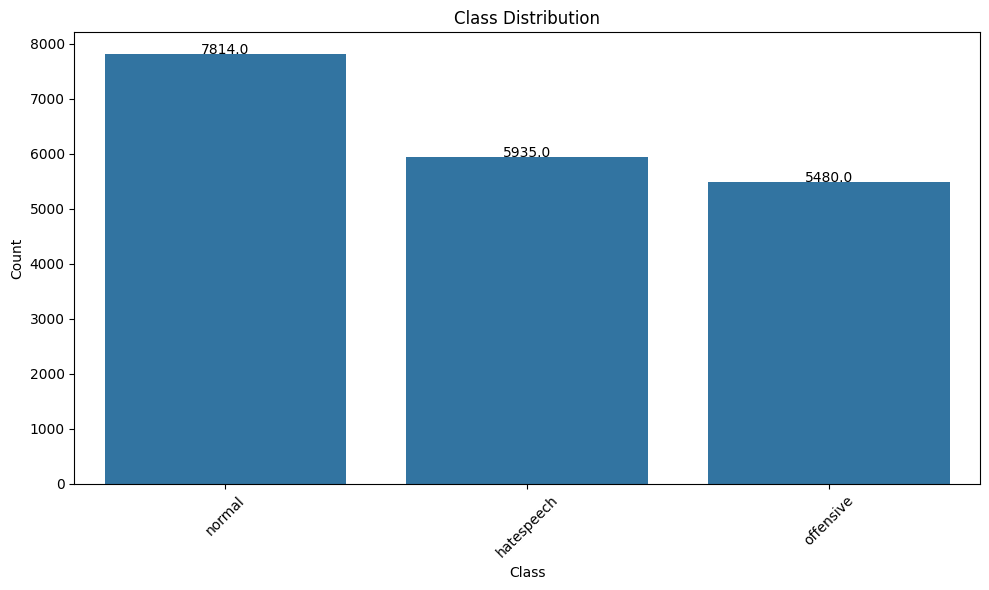

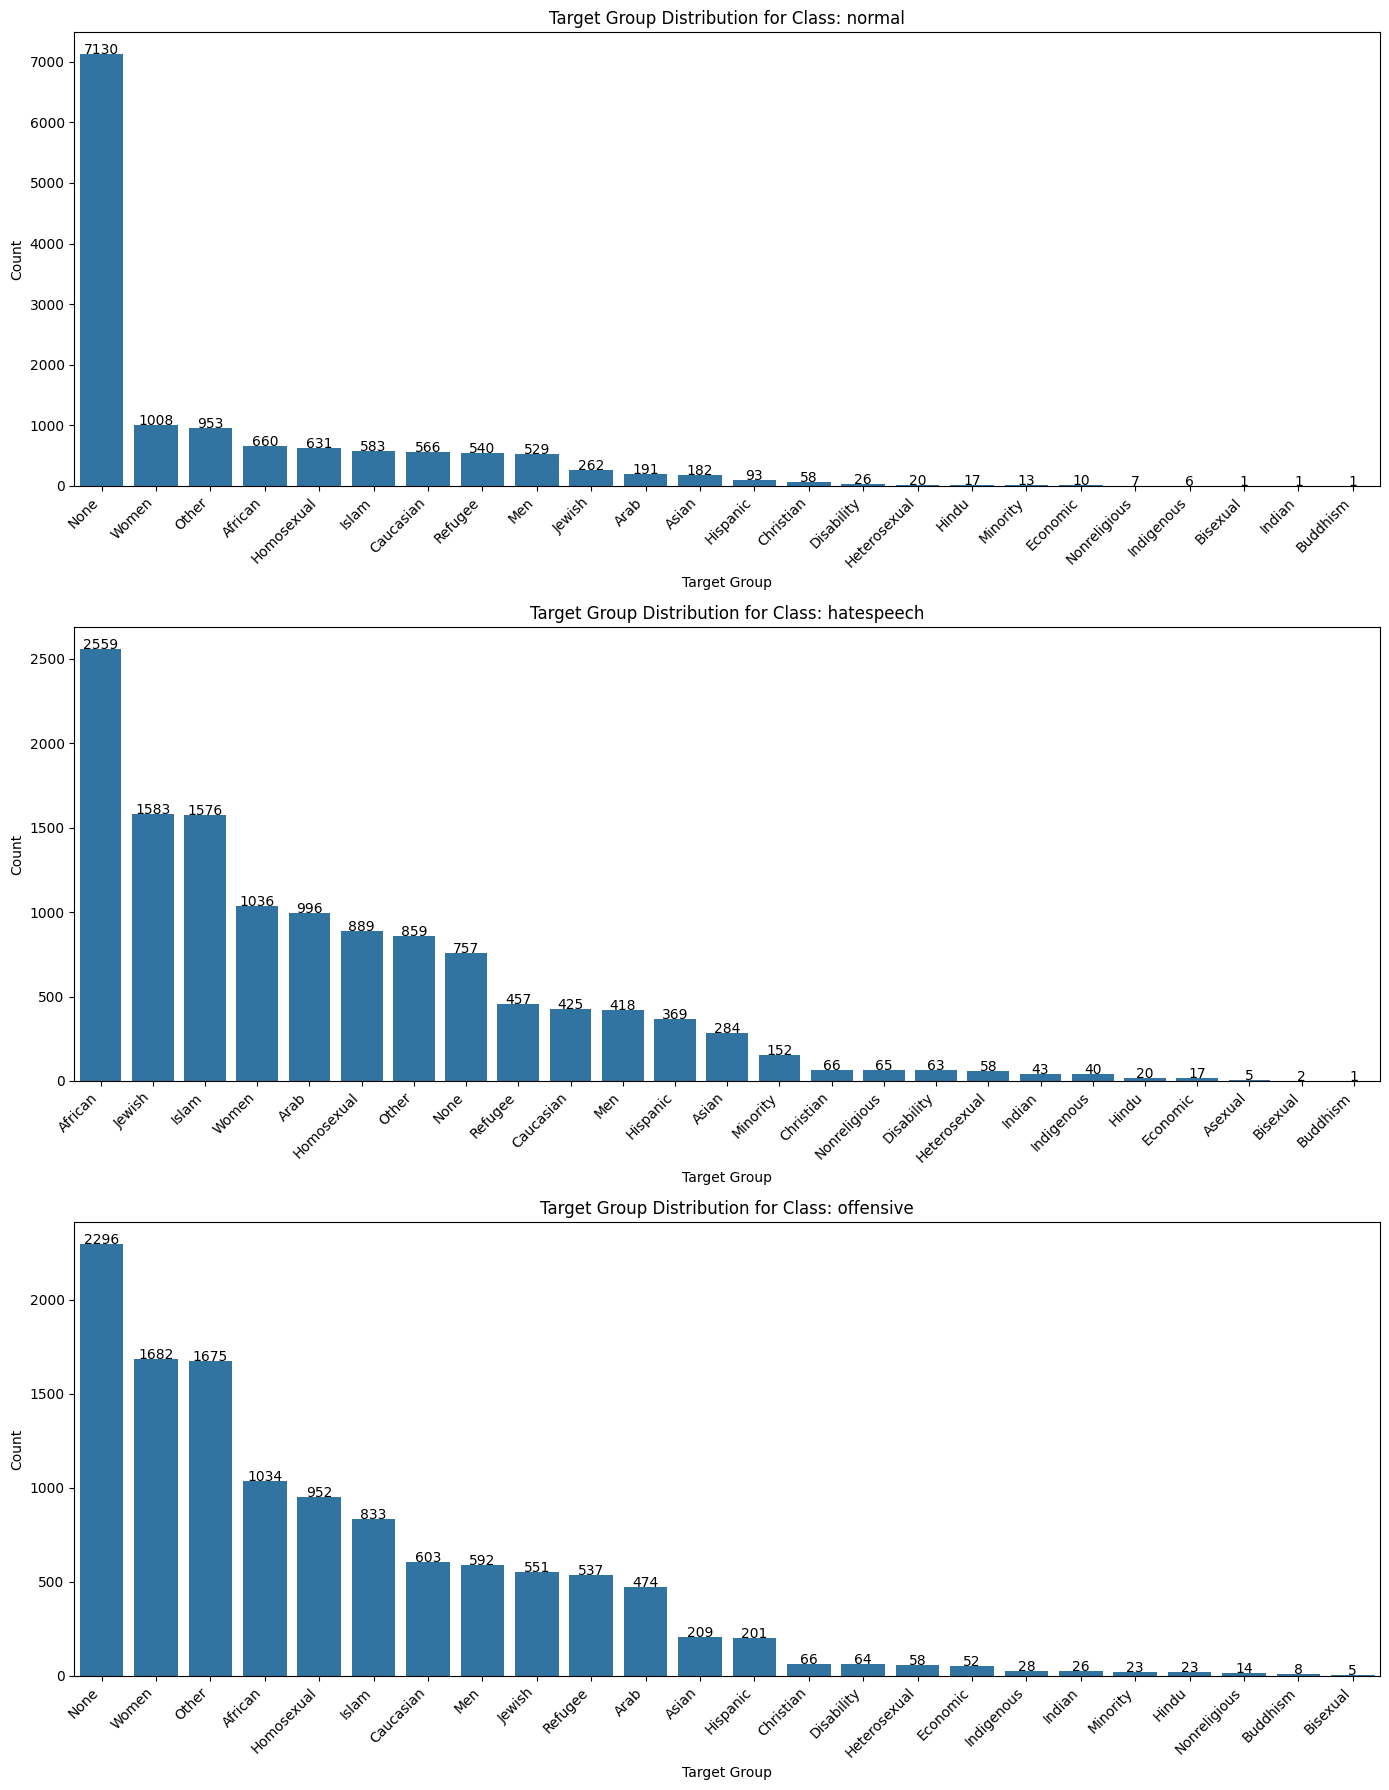

In [5]:
plot_class_distribution(data_3class)
plot_target_group_distribution_by_class(data_3class)

Target variable is not balanced, hence we modify the CrossEntropy loss function to account for the imbalance by using the class weights.

# Training

Running model comparison...

=== Running 3-Class Classification Models ===


Training bert-base-uncased for 3-class classification
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}

Epoch 1/1


Training: 100%|██████████| 974/974 [08:00<00:00,  2.03batch/s, loss=0.798]


Average training loss: 0.0000


Evaluating: 100%|██████████| 109/109 [00:16<00:00,  6.50batch/s]


Validation loss: 0.7168
Validation accuracy: 0.6898
Validation F1 score: 0.6822


Evaluating: 100%|██████████| 121/121 [00:18<00:00,  6.49batch/s]



Test Results:
Loss: 0.6968
Accuracy: 0.7010
Macro F1 Score: 0.6937


Predicting: 100%|██████████| 121/121 [00:18<00:00,  6.48batch/s]


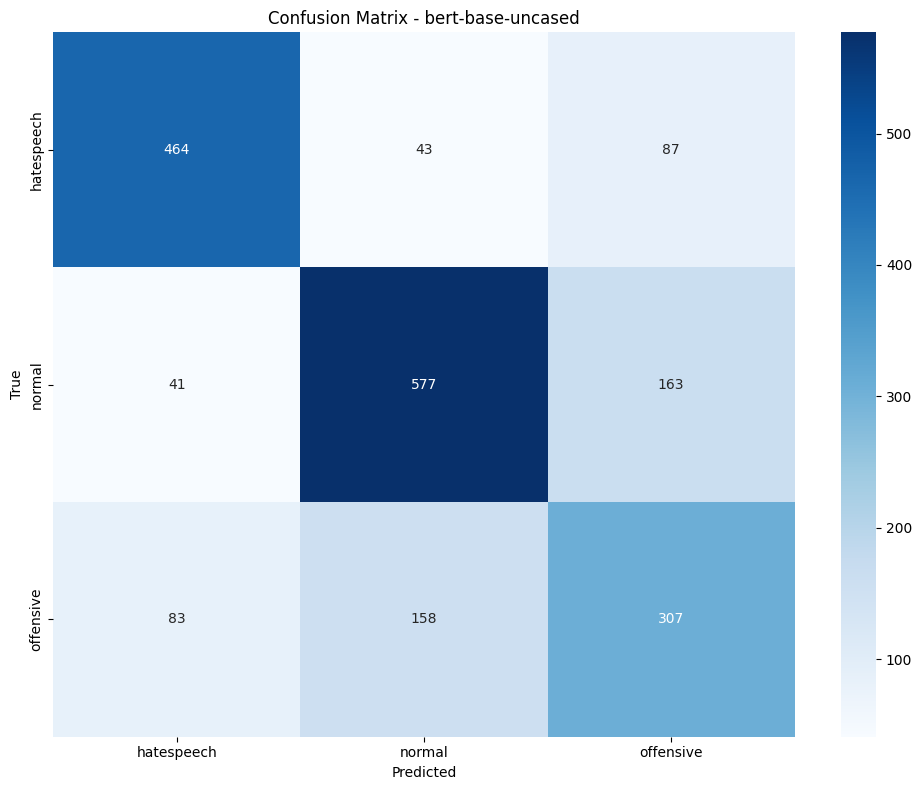

Model saved to saved_models\bert-base-uncased_3class

Performance by Target Group:
None: Accuracy = 0.7028 (n=1006)
African: Accuracy = 0.7370 (n=441)
Women: Accuracy = 0.6712 (n=368)
Other: Accuracy = 0.6658 (n=365)
Islam: Accuracy = 0.6357 (n=280)
Homosexual: Accuracy = 0.5941 (n=239)
Jewish: Accuracy = 0.7051 (n=234)
Caucasian: Accuracy = 0.6591 (n=176)
Refugee: Accuracy = 0.5901 (n=161)
Men: Accuracy = 0.6497 (n=157)

Training distilbert-base-uncased for 3-class classification
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}

Epoch 1/1


Training: 100%|██████████| 974/974 [04:09<00:00,  3.91batch/s, loss=0.47] 


Average training loss: 0.0000


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.69batch/s]


Validation loss: 0.7366
Validation accuracy: 0.6857
Validation F1 score: 0.6800


Evaluating: 100%|██████████| 121/121 [00:09<00:00, 12.66batch/s]



Test Results:
Loss: 0.7168
Accuracy: 0.6828
Macro F1 Score: 0.6719


Predicting: 100%|██████████| 121/121 [00:09<00:00, 12.68batch/s]


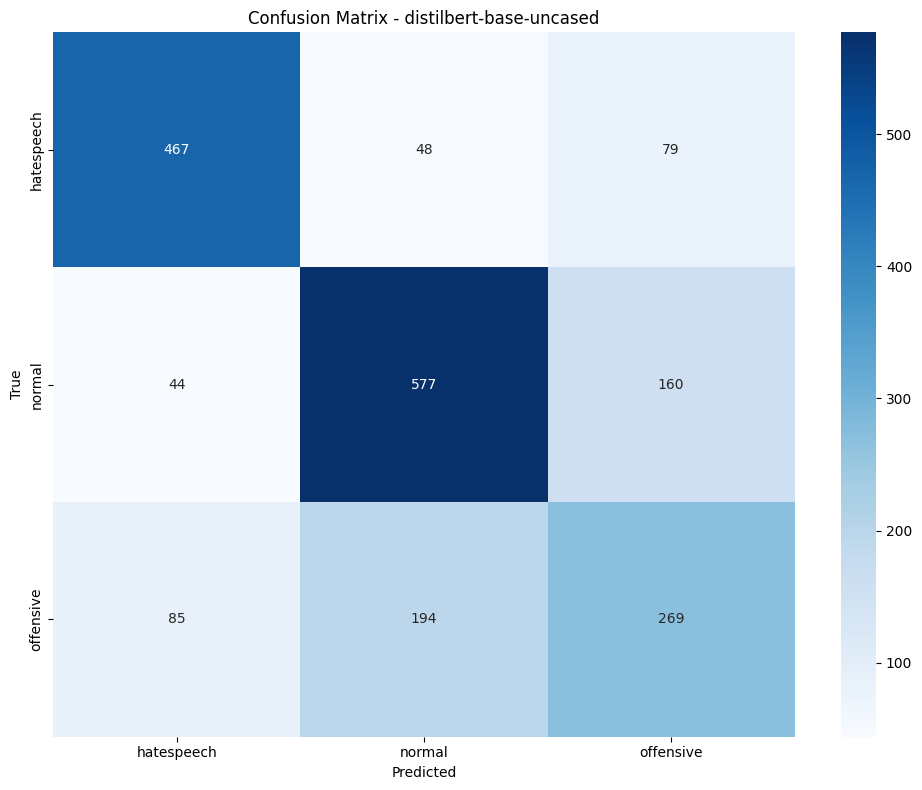

Model saved to saved_models\distilbert-base-uncased_3class

Performance by Target Group:
None: Accuracy = 0.6918 (n=1006)
African: Accuracy = 0.7234 (n=441)
Women: Accuracy = 0.6332 (n=368)
Other: Accuracy = 0.6521 (n=365)
Islam: Accuracy = 0.6143 (n=280)
Homosexual: Accuracy = 0.5732 (n=239)
Jewish: Accuracy = 0.7137 (n=234)
Caucasian: Accuracy = 0.6307 (n=176)
Refugee: Accuracy = 0.5652 (n=161)
Men: Accuracy = 0.6433 (n=157)

=== Running Binary Classification Models ===


Training bert-base-uncased for binary classification
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}

Epoch 1/1


Training: 100%|██████████| 974/974 [08:03<00:00,  2.02batch/s, loss=0.489]


Average training loss: 0.0000


Evaluating: 100%|██████████| 109/109 [00:16<00:00,  6.49batch/s]


Validation loss: 0.4490
Validation accuracy: 0.7949
Validation F1 score: 0.7919


Evaluating: 100%|██████████| 121/121 [00:18<00:00,  6.48batch/s]



Test Results:
Loss: 0.4551
Accuracy: 0.7806
Macro F1 Score: 0.7763


Predicting: 100%|██████████| 121/121 [00:18<00:00,  6.48batch/s]


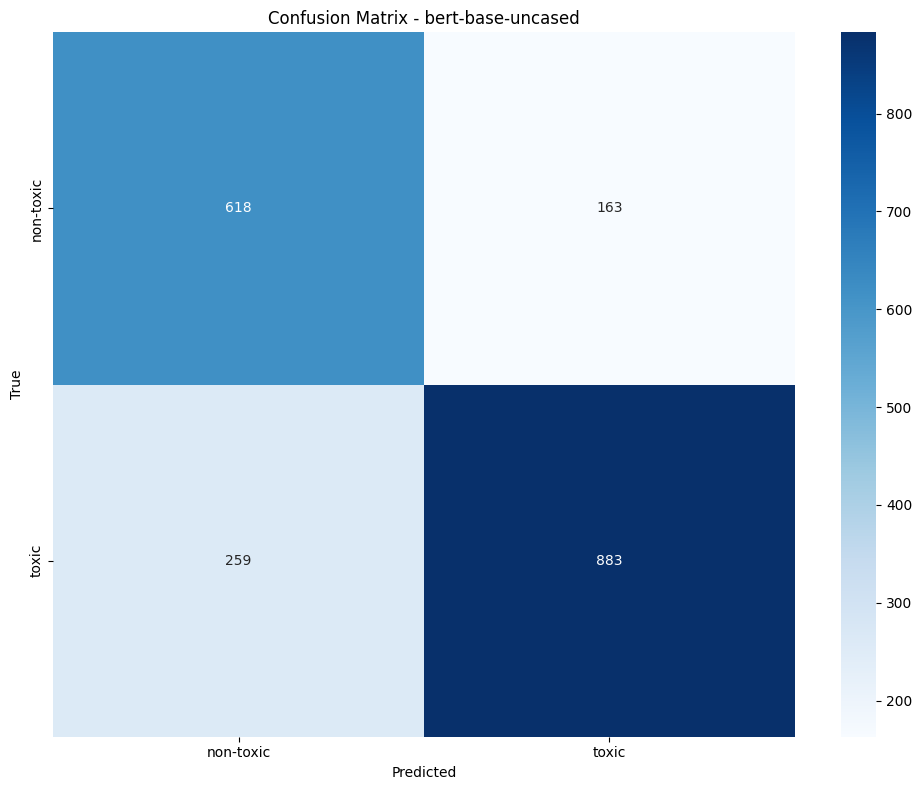

Model saved to saved_models\bert-base-uncased_binary

Performance by Target Group:
None: Accuracy = 0.7564 (n=1010)
African: Accuracy = 0.8103 (n=448)
Women: Accuracy = 0.7236 (n=369)
Other: Accuracy = 0.7796 (n=363)
Islam: Accuracy = 0.7770 (n=305)
Homosexual: Accuracy = 0.7927 (n=246)
Jewish: Accuracy = 0.8673 (n=226)
Arab: Accuracy = 0.8314 (n=172)
Men: Accuracy = 0.7692 (n=169)
Caucasian: Accuracy = 0.7099 (n=162)

Training distilbert-base-uncased for binary classification
Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}

Epoch 1/1


Training: 100%|██████████| 974/974 [04:10<00:00,  3.89batch/s, loss=0.677]


Average training loss: 0.0000


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.63batch/s]


Validation loss: 0.4386
Validation accuracy: 0.7839
Validation F1 score: 0.7797


Evaluating: 100%|██████████| 121/121 [00:09<00:00, 12.62batch/s]



Test Results:
Loss: 0.4513
Accuracy: 0.7764
Macro F1 Score: 0.7711


Predicting: 100%|██████████| 121/121 [00:09<00:00, 12.64batch/s]


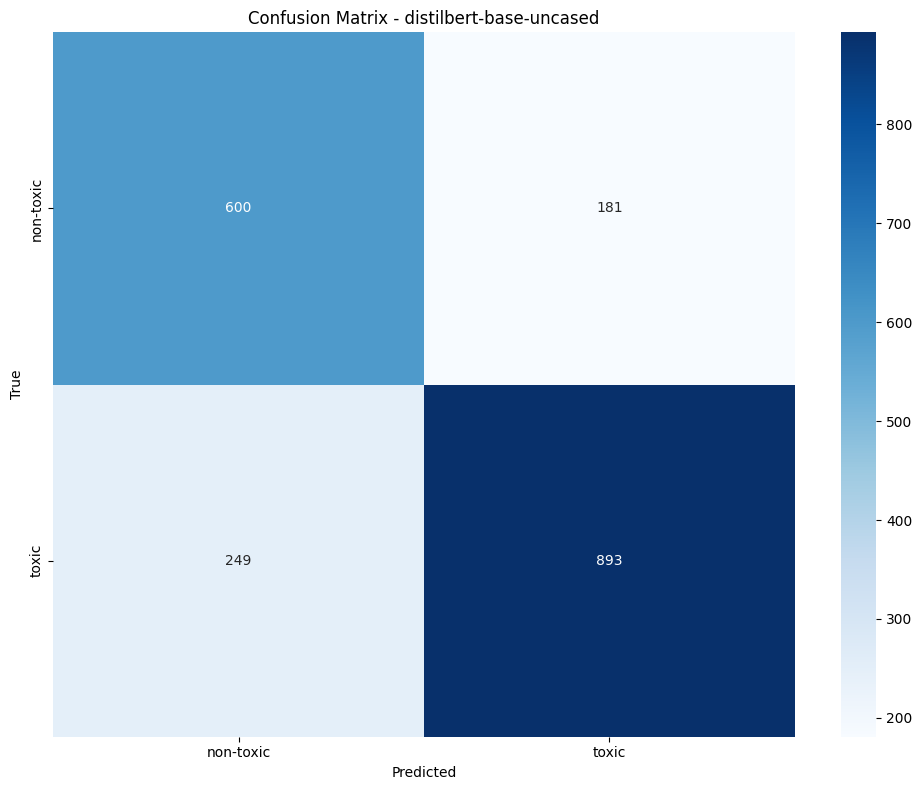

Model saved to saved_models\distilbert-base-uncased_binary

Performance by Target Group:
None: Accuracy = 0.7347 (n=1010)
African: Accuracy = 0.8103 (n=448)
Women: Accuracy = 0.7317 (n=369)
Other: Accuracy = 0.7686 (n=363)
Islam: Accuracy = 0.8000 (n=305)
Homosexual: Accuracy = 0.7683 (n=246)
Jewish: Accuracy = 0.8761 (n=226)
Arab: Accuracy = 0.8488 (n=172)
Men: Accuracy = 0.7988 (n=169)
Caucasian: Accuracy = 0.7099 (n=162)


In [6]:
models_to_compare = MODELS
print("Running model comparison...")
comparison_results = run_model_comparison(
    models_to_compare,
    data_3class,
    data_2class,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    auto_weighted=True
)


Analyzing results...

Model Comparison Summary:
                     Model    Task  Accuracy  F1 Score  Precision  Recall  \
2        bert-base-uncased  3class    0.7010    0.6937     0.6940  0.6934   
3  distilbert-base-uncased  3class    0.6828    0.6719     0.6725  0.6720   
0        bert-base-uncased  binary    0.7806    0.7763     0.7744  0.7822   
1  distilbert-base-uncased  binary    0.7764    0.7711     0.7691  0.7751   

    AUROC  Bias Score  
2  0.8567      0.0674  
3  0.8461      0.0790  
0  0.8667      0.0573  
1  0.8661      0.0637  


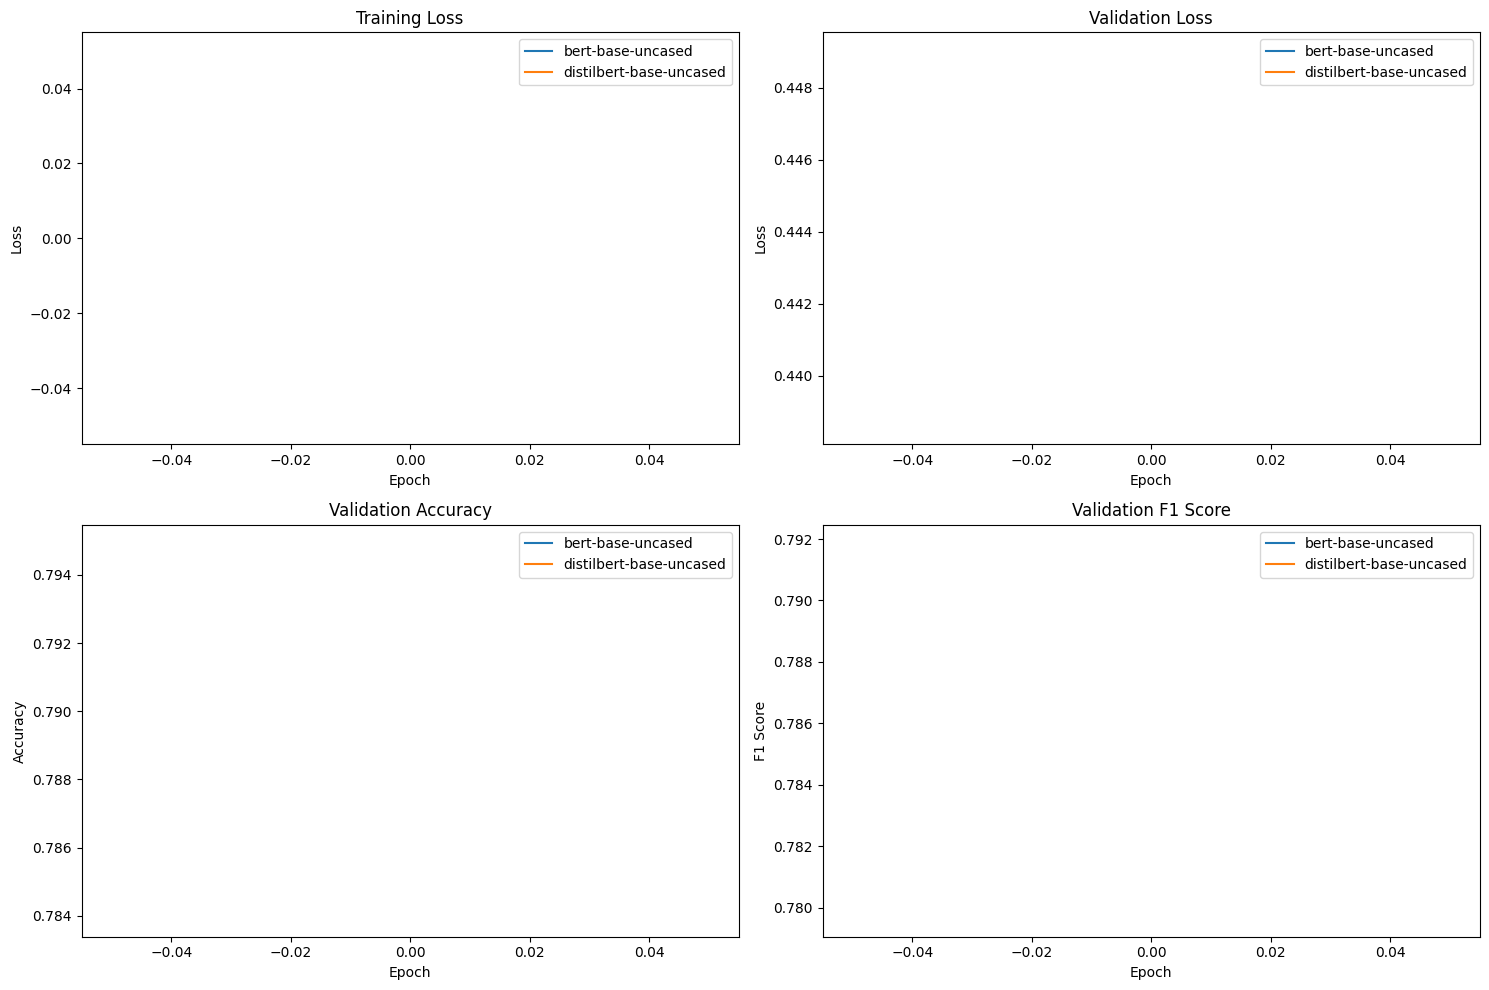

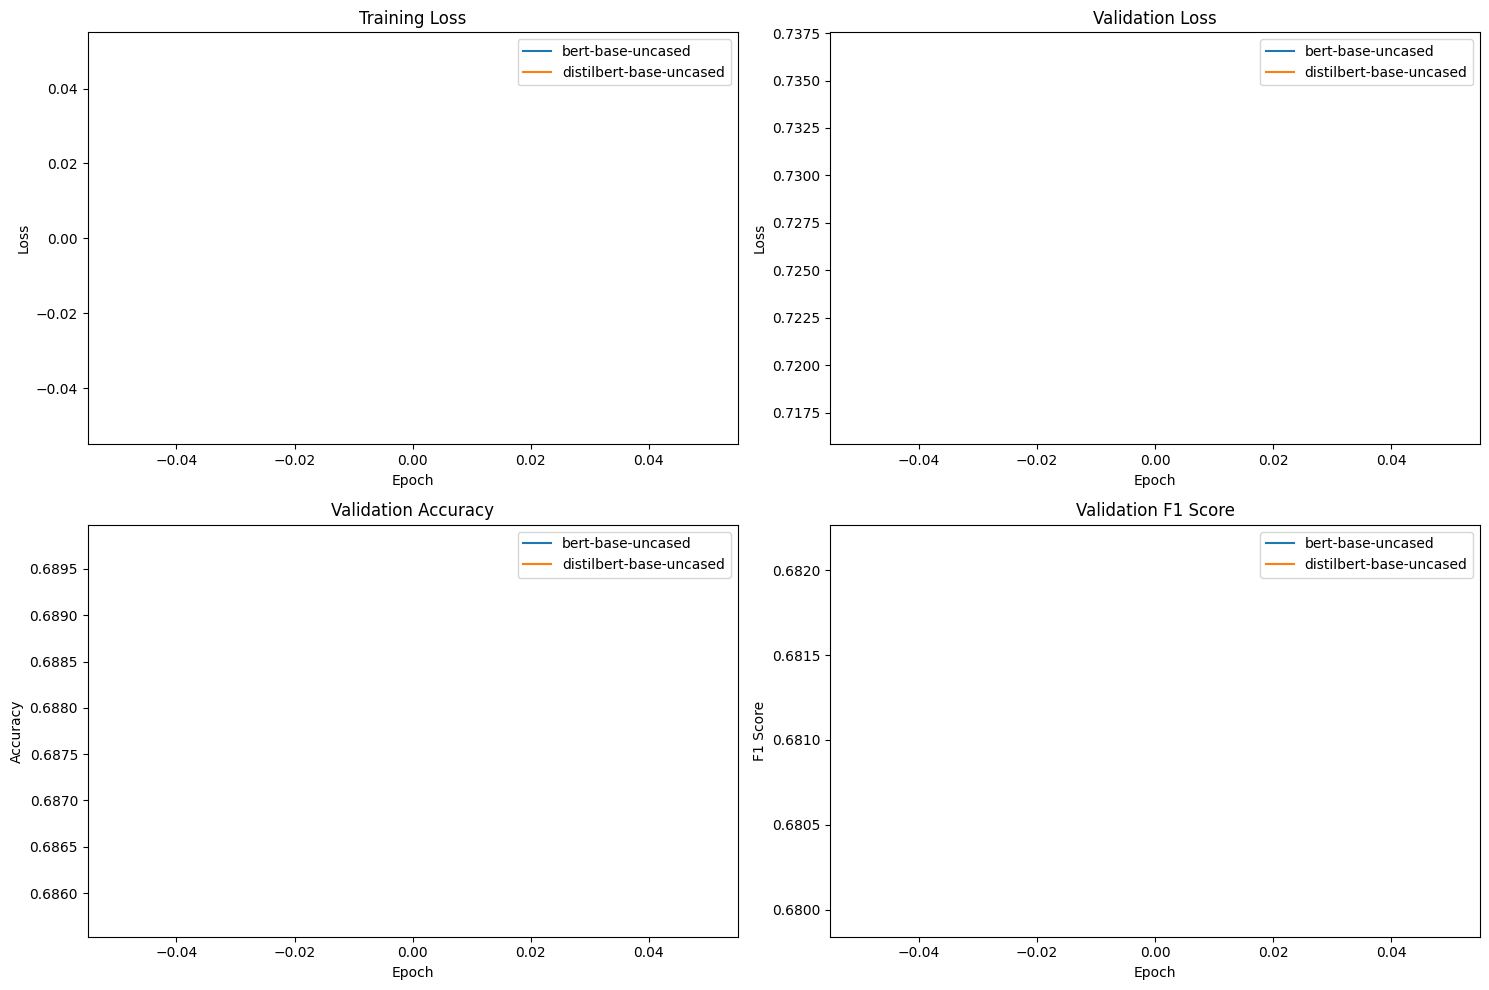

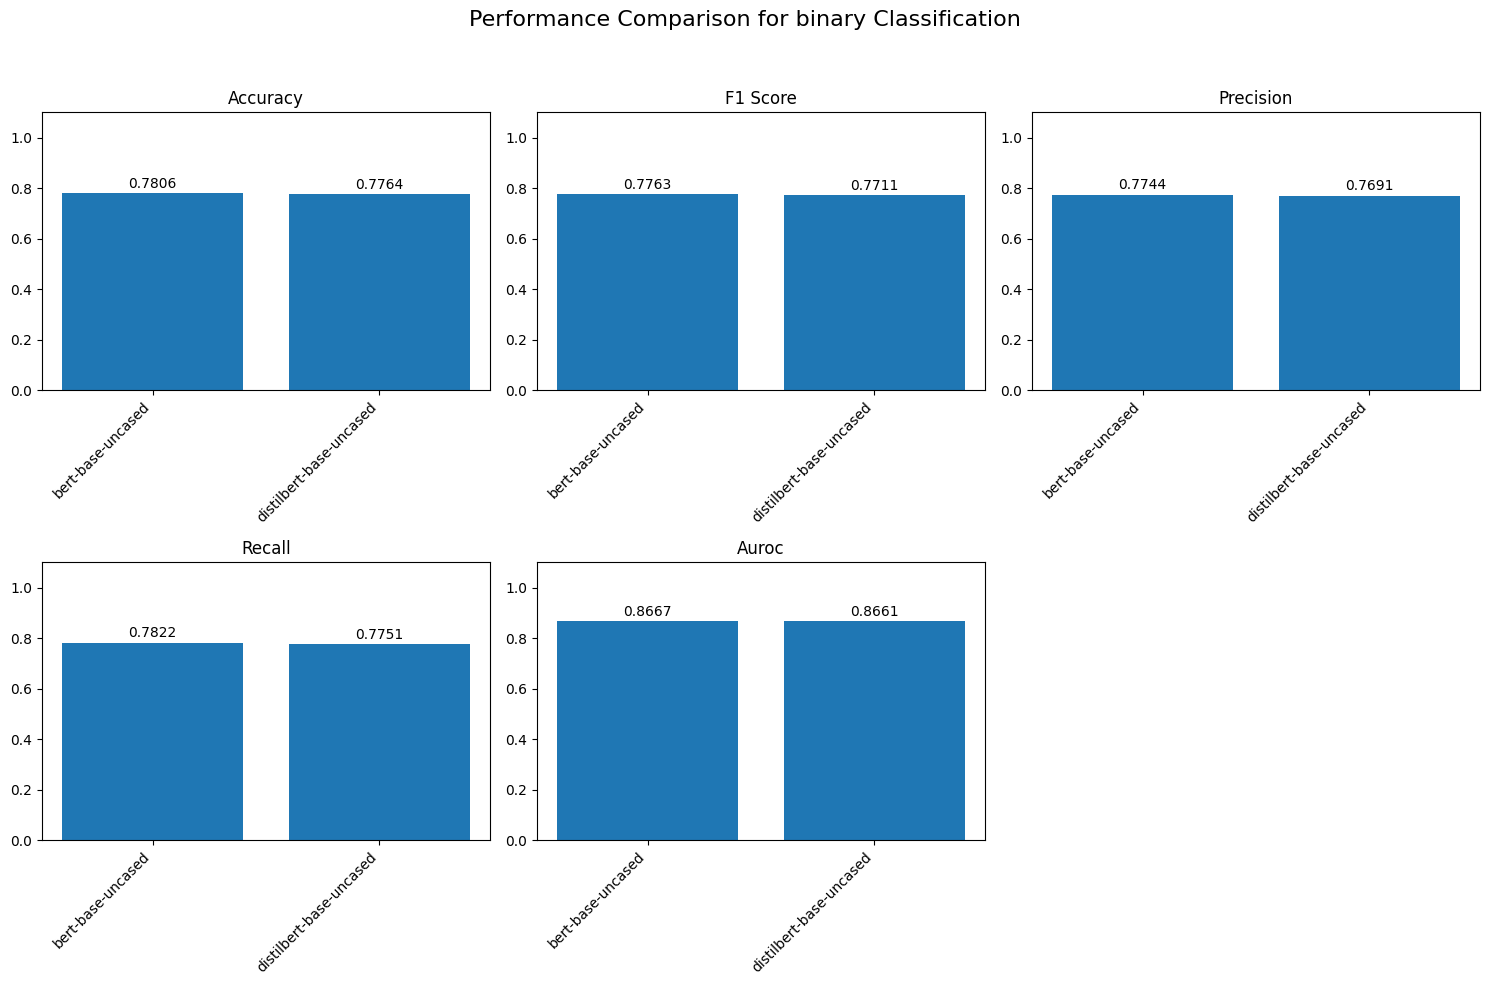

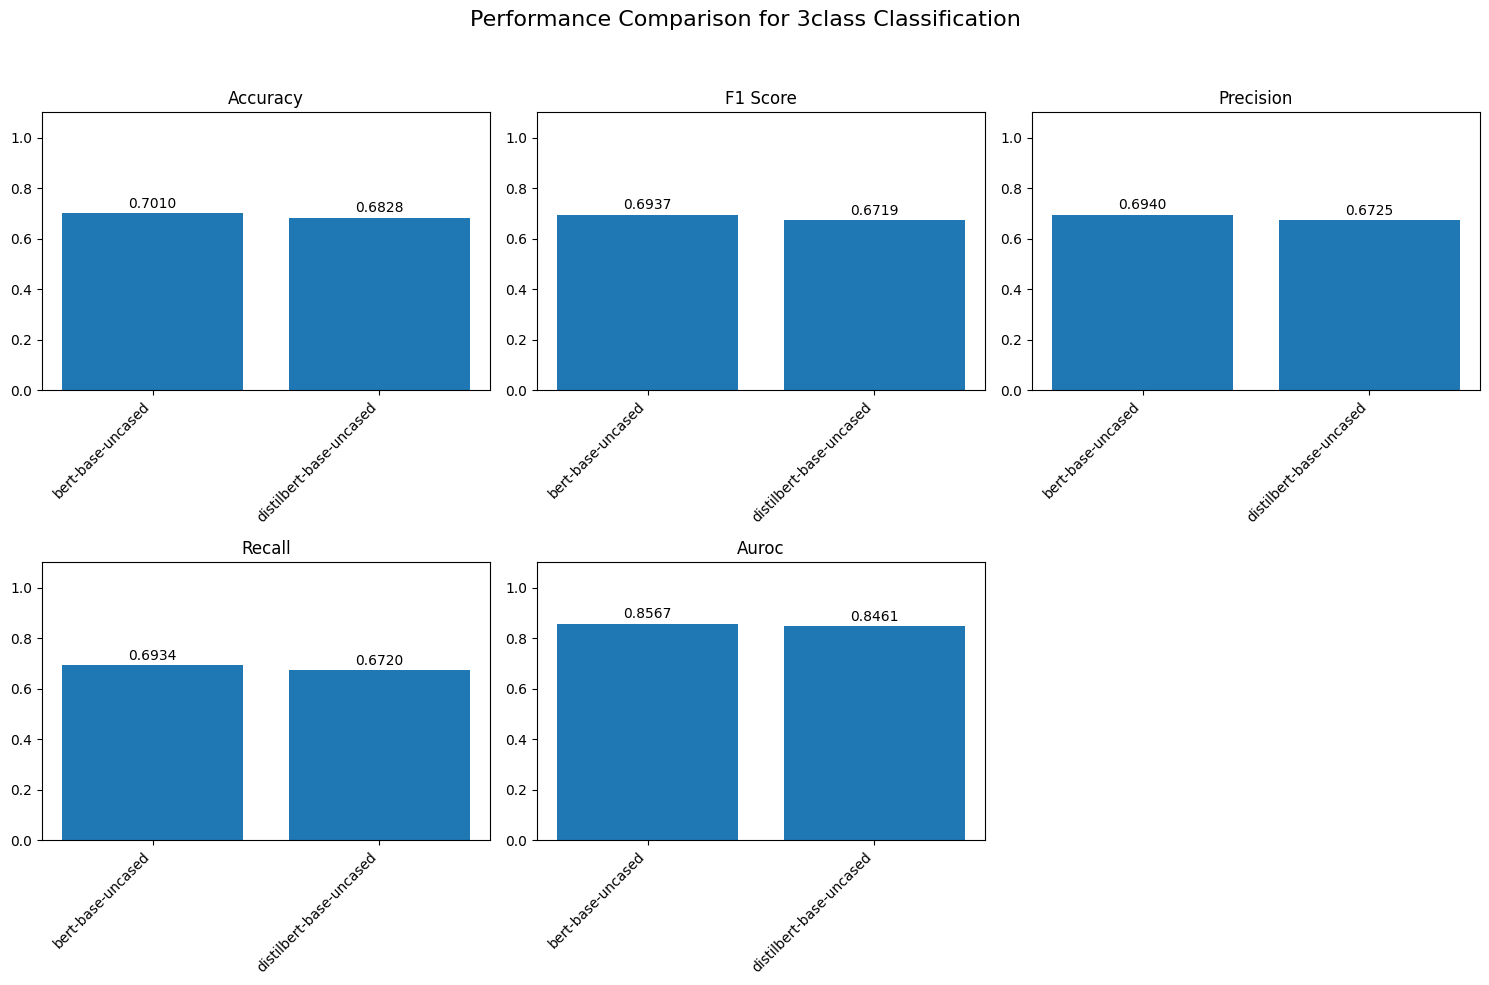


=== Bias Analysis for binary Classification ===


Model: bert-base-uncased
Performance across target groups:
Mean accuracy: 0.7817
Standard deviation: 0.0448
Min accuracy: 0.7099
Max accuracy: 0.8673
Max-Min difference: 0.1574
Target group with worst performance: Caucasian (accuracy: 0.7099)
Target group with best performance: Jewish (accuracy: 0.8673)
Bias score (normalized std): 0.0573

Model: distilbert-base-uncased
Performance across target groups:
Mean accuracy: 0.7847
Standard deviation: 0.0500
Min accuracy: 0.7099
Max accuracy: 0.8761
Max-Min difference: 0.1662
Target group with worst performance: Caucasian (accuracy: 0.7099)
Target group with best performance: Jewish (accuracy: 0.8761)
Bias score (normalized std): 0.0637

=== Bias Analysis for 3class Classification ===


Model: bert-base-uncased
Performance across target groups:
Mean accuracy: 0.6611
Standard deviation: 0.0446
Min accuracy: 0.5901
Max accuracy: 0.7370
Max-Min difference: 0.1469
Target group with worst performa

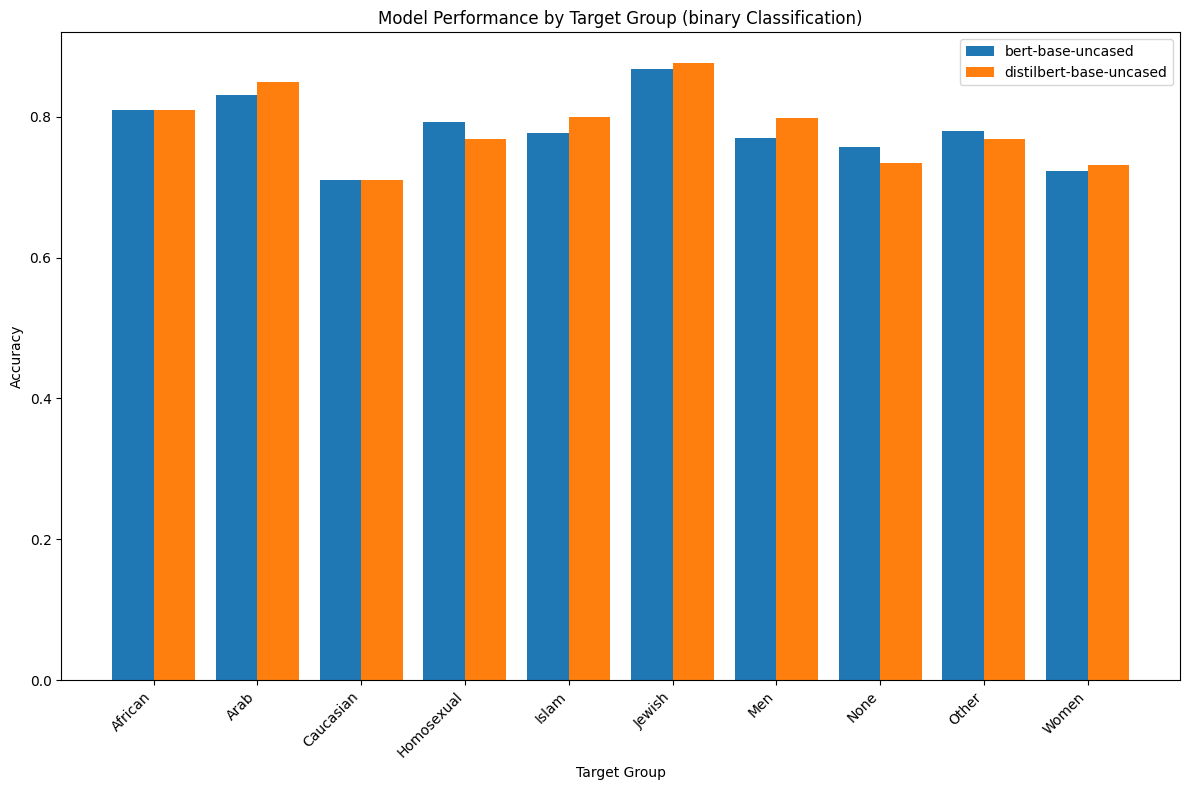

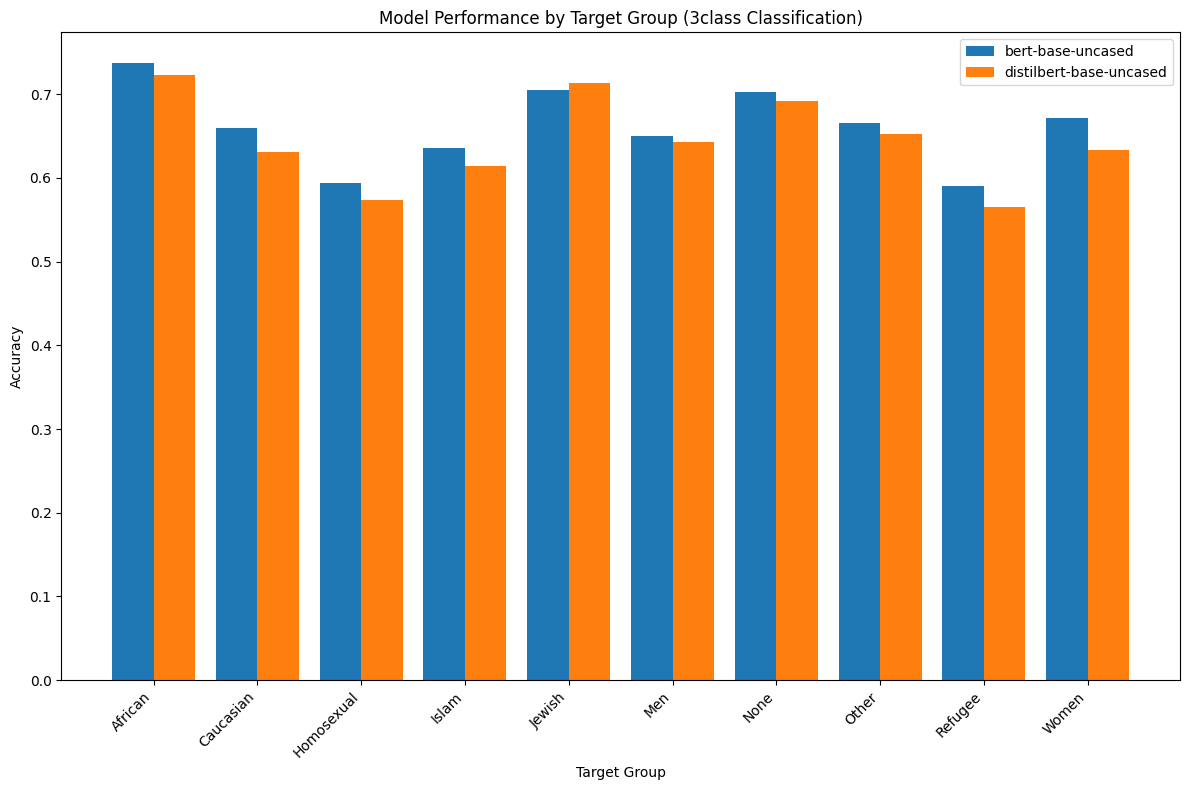


=== Error Analysis for bert-base-uncased on binary Classification ===

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from saved_models/bert-base-uncased_binary


Predicting: 100%|██████████| 121/121 [00:18<00:00,  6.64batch/s]


High-confidence errors (model was confident but wrong):

Example 1:
Text: i kike the idea of an uncensored social media app but why no iphone app why is not there more advertising there also needs to be something more unique about it other than free speech
True label: non-toxic
Predicted label: toxic
Confidence: 0.9542
Target groups: Jewish, None

Example 2:
Text: if we could teach a giraffe to paint that would be one handy sumbitch
True label: non-toxic
Predicted label: toxic
Confidence: 0.9484
Target groups: None

Example 3:
Text: israel is the only democracy in the muzzie mideast and an american ally people who hate israel are idiots
True label: non-toxic
Predicted label: toxic
Confidence: 0.9440
Target groups: None, Islam

Example 4:
Text: <user> why the hell did this mentally challenged individual parents allow him to go to a sleepover with a retarded ghetto nigger maybe the we are all one race the human race crap had filled their heads maybe they are tired of caring for him not w

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from saved_models/bert-base-uncased_3class


Predicting: 100%|██████████| 121/121 [00:18<00:00,  6.62batch/s]


High-confidence errors (model was confident but wrong):

Example 1:
Text: jew jews his way into becoming prime minister of huwhytopia poland kike kikes his way to municipality judicial head in majority white porto alegre brazil guys the time for heroes is now if you have nothing to lose you know what to do conanism
True label: offensive
Predicted label: hatespeech
Confidence: 0.9414
Target groups: Jewish

Example 2:
Text: i like bro nathaniel he near the mark on most every topic and is the only kike willing to rip his own to shreds good vids
True label: offensive
Predicted label: hatespeech
Confidence: 0.9355
Target groups: Jewish

Example 3:
Text: and some kike loving people with degrees who are fucking delusional
True label: offensive
Predicted label: hatespeech
Confidence: 0.9333
Target groups: Jewish, None

Example 4:
Text: ancient made up european gods and ancient made up kike gods are the exact same thing if you are not worshiping actual god you are worshipping someone else that 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:09<00:00,  6.64batch/s]



Analyzing distilbert-base-uncased...
Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:04<00:00, 12.92batch/s]



Efficiency Results:
                     Model  Parameters (M)  Inference Time (s)  Samples/Second
1  distilbert-base-uncased         66.9558              4.7284        203.4505
0        bert-base-uncased        109.4845              9.1891        104.6895


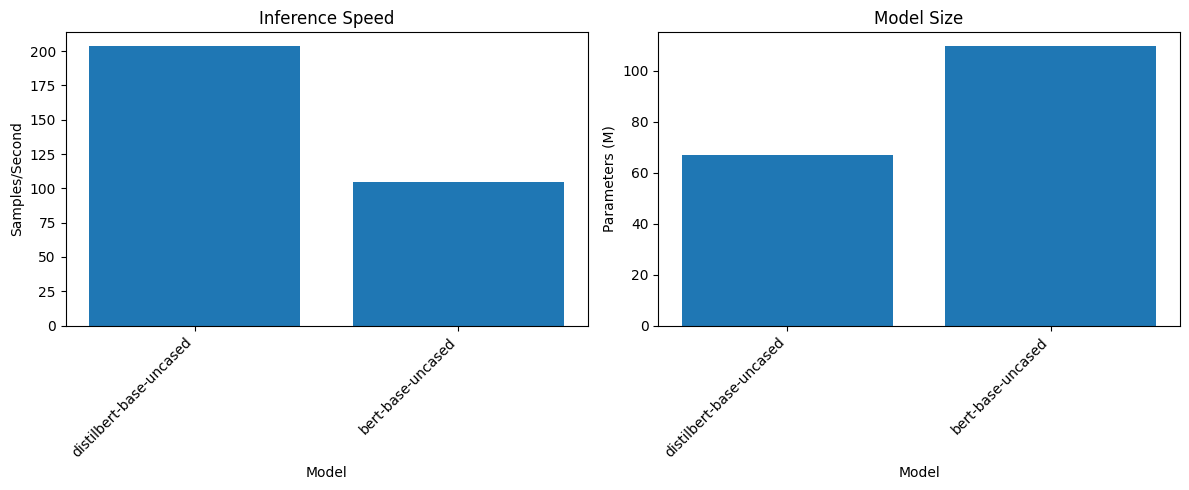


=== FINAL CONCLUSIONS ===

Best model for binary classification:
bert-base-uncased: F1 Score = 0.7763, Accuracy = 0.7806

Best model for 3-class classification:
bert-base-uncased: F1 Score = 0.6937, Accuracy = 0.7010

Most efficient model: distilbert-base-uncased (203.45 samples/second)

Best balance of performance and efficiency:
distilbert-base-uncased on binary task
F1 Score: 0.7711
Inference Speed: 203.45 samples/second
Model Size: 66.96 million parameters

Recommendations:
1. For production environments where speed is critical, consider using a distilled model
2. For applications requiring high accuracy, especially in detecting hate speech, use the best performing model
3. For a balance of performance and efficiency, consider the model with the best balanced score
4. Further research should focus on reducing bias across target groups, as performance varies significantly
All results saved to the 'results' directory

=== Project completed successfully ===


In [9]:
# Analyze results
print("\nAnalyzing results...")

# Create summary table
summary_table = create_summary_table(comparison_results)
print("\nModel Comparison Summary:")
pd.set_option('display.precision', 4)
print(summary_table)

# Plot training history
plot_training_history(comparison_results, task_type='binary')
plot_training_history(comparison_results, task_type='3class')

# Plot performance comparison
plot_performance_comparison(comparison_results)

# Analyze bias
analyze_bias(comparison_results, task_type='binary')
analyze_bias(comparison_results, task_type='3class')

# Plot target group performance
plot_target_group_performance(comparison_results, task_type='binary')
plot_target_group_performance(comparison_results, task_type='3class')

# Analyze errors for best models
binary_best_model = summary_table[summary_table['Task'] == 'binary'].sort_values('F1 Score', ascending=False).iloc[0]['Model']
multiclass_best_model = summary_table[summary_table['Task'] == '3class'].sort_values('F1 Score', ascending=False).iloc[0]['Model']

# Get the full model name for analysis
for model_name in models_to_compare:
    if model_name.split('/')[-1] == binary_best_model:
        binary_best_model_full = model_name
    if model_name.split('/')[-1] == multiclass_best_model:
        multiclass_best_model_full = model_name

# Error analysis
analyze_errors(
    comparison_results, 
    data_2class, 
    task_type='binary',
    model_name=binary_best_model_full
)

analyze_errors(
    comparison_results, 
    data_3class, 
    task_type='3class',
    model_name=multiclass_best_model_full
)

# Efficiency analysis
efficiency_results = analyze_efficiency(
    models_to_compare,
    data_3class,
    num_classes=3,
    batch_size=BATCH_SIZE
)

# Generate conclusions
generate_conclusions(summary_table, efficiency_results)

# Save results
save_results(comparison_results, summary_table, efficiency_results)

print("\n=== Project completed successfully ===")


# Example

Loading and preprocessing data...


Processing entries: 100%|██████████| 20148/20148 [00:00<00:00, 22027.82entry/s]


Initial data: 20148
Uncertain data: 919
Total final data count: 19229

Visualize class distribution


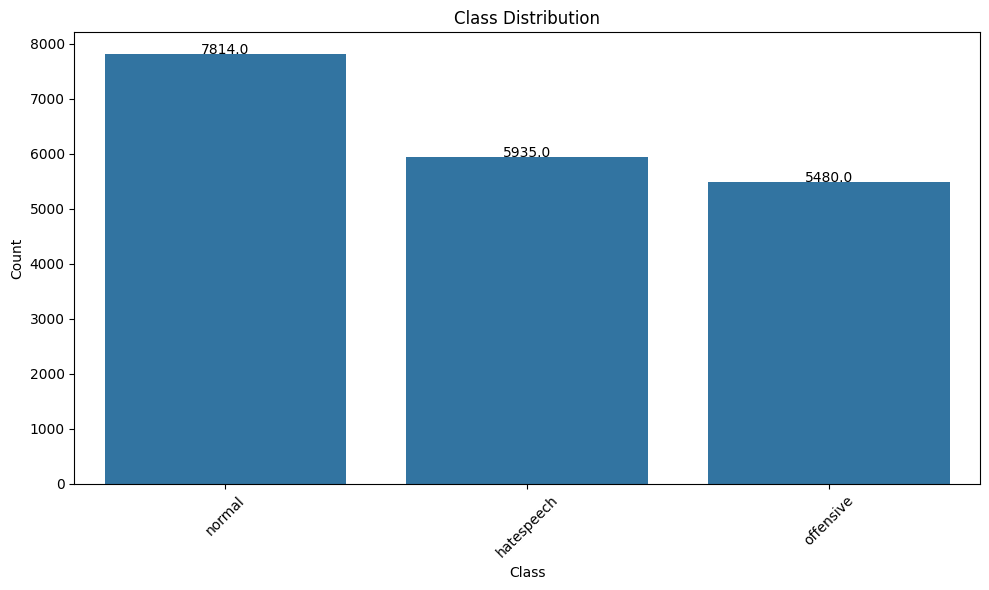


Visualize target group distribution


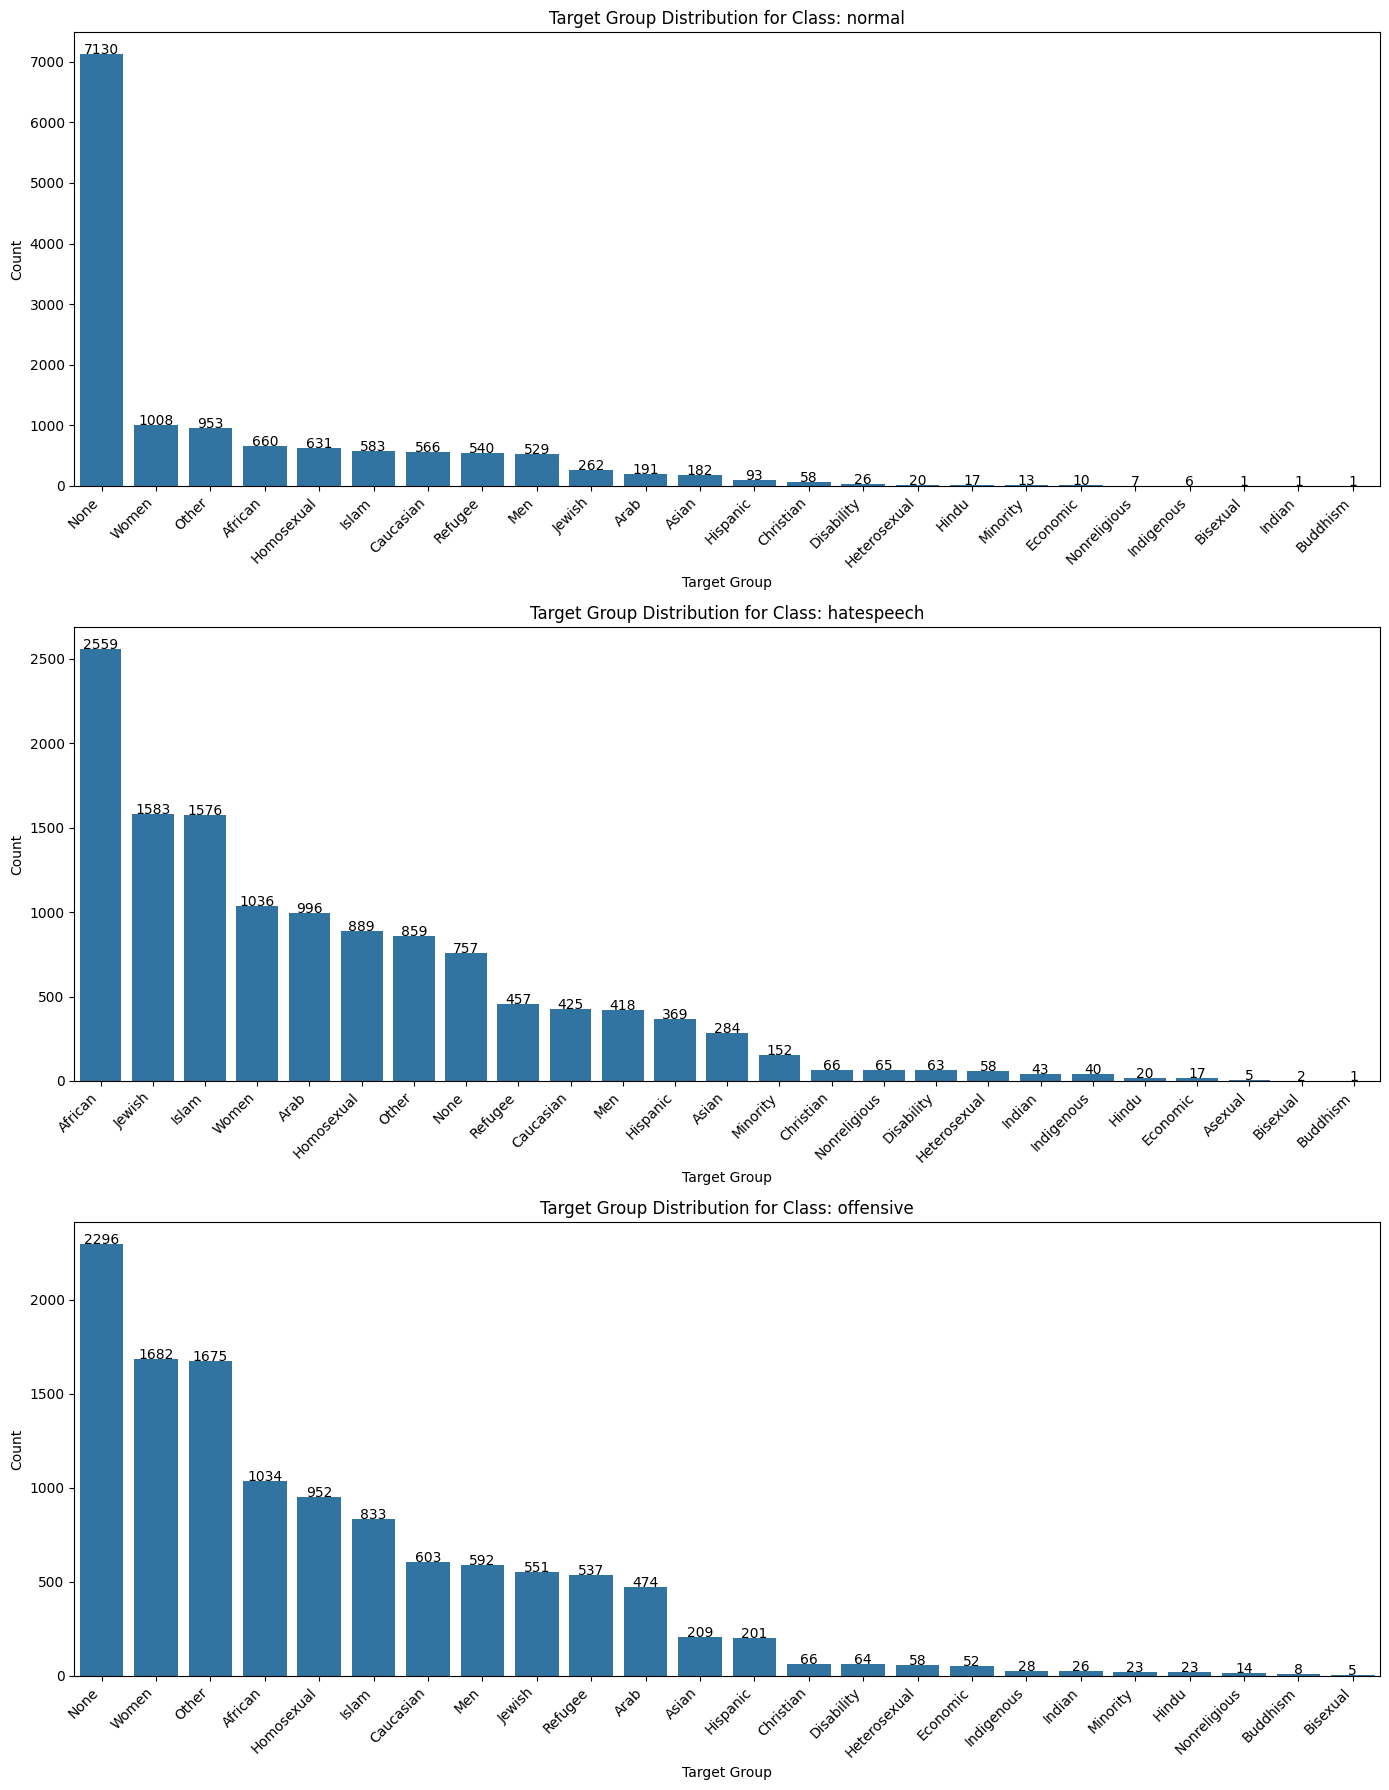


Training a single model...
Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set: 15575, Validation set: 1731, Test set: 1923

Epoch 1/2


Training: 100%|██████████| 974/974 [04:09<00:00,  3.90batch/s, loss=1.05] 


Average training loss: 0.0000


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.63batch/s]


Validation loss: 0.7022
Validation accuracy: 0.7048
Validation F1 score: 0.6902

Epoch 2/2


Training: 100%|██████████| 974/974 [04:10<00:00,  3.89batch/s, loss=0.873]


Average training loss: 0.0000


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.51batch/s]


Validation loss: 0.6951
Validation accuracy: 0.7129
Validation F1 score: 0.7018


Evaluating: 100%|██████████| 121/121 [00:09<00:00, 12.66batch/s]


Test Results:
Loss: 0.6919
Accuracy: 0.7051
F1 Score: 0.6915

Testing model on custom input...
Text: I hate those people from that country
Predicted class: normal
Confidence: 0.8946
hatespeech: 0.0153
normal: 0.8946
offensive: 0.0901


In [15]:
"""Example script showing how to run specific parts of the project."""

import pandas as pd
from config import DATASET_PATH, MODELS
from data.preprocessing import load_raw_data, preprocess_dataset
from utils.helpers import set_seed, add_new_model
from visualization.plots import plot_class_distribution, plot_target_group_distribution_by_class

# Set random seed for reproducibility
set_seed(42)

# Load and preprocess data
print("Loading and preprocessing data...")
raw_data = load_raw_data(DATASET_PATH)
data_3class = preprocess_dataset(raw_data, num_classes=3)

# Example 1: Visualize class distribution
print("\nVisualize class distribution")
plot_class_distribution(data_3class)

# Example 2: Add a new model to the comparison
if 'target_groups' in data_3class.columns:
    print("\nVisualize target group distribution")
    plot_target_group_distribution_by_class(data_3class)

# Example 3: Train and evaluate a single model
print("\nTraining a single model...")
from models.classifier import TransformerClassifier
from data.dataset import prepare_data_loaders

# Initialize model
model_name = 'distilbert-base-uncased'
classifier = TransformerClassifier(model_name, num_labels=3)

# Prepare data loaders
train_dataloader, val_dataloader, test_dataloader, label_map, test_df, weights = prepare_data_loaders(
    data_3class,
    classifier.tokenizer,
    batch_size=16
)

# Train model for just 2 epochs as an example
history = classifier.train(train_dataloader, val_dataloader, epochs=2)

# Evaluate on test set
test_loss, test_accuracy, test_f1 = classifier.evaluate(test_dataloader)
print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Example 4: Test on a custom input
print("\nTesting model on custom input...")
custom_text = "I hate those people from that country"

# Tokenize and prepare input
encoding = classifier.tokenizer(
    custom_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Move to device
input_ids = encoding['input_ids'].to(classifier.device)
attention_mask = encoding['attention_mask'].to(classifier.device)

# Make prediction
import torch
classifier.model.eval()
with torch.no_grad():
    outputs = classifier.model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    prediction = torch.argmax(logits, dim=1).item()

# Display result
inv_label_map = {v: k for k, v in label_map.items()}
predicted_label = inv_label_map[prediction]
print(f"Text: {custom_text}")
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {probabilities[0][prediction].item():.4f}")

# Show probabilities for all classes
for label, idx in label_map.items():
    print(f"{label}: {probabilities[0][idx].item():.4f}")

In [16]:
# Example 4: Test on a custom input
print("\nTesting model on custom input...")
custom_text = "I hate those nigga bitches that suck dick like a monkey"

# Tokenize and prepare input
encoding = classifier.tokenizer(
    custom_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Move to device
input_ids = encoding['input_ids'].to(classifier.device)
attention_mask = encoding['attention_mask'].to(classifier.device)

# Make prediction
import torch
classifier.model.eval()
with torch.no_grad():
    outputs = classifier.model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    prediction = torch.argmax(logits, dim=1).item()

# Display result
inv_label_map = {v: k for k, v in label_map.items()}
predicted_label = inv_label_map[prediction]
print(f"Text: {custom_text}")
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {probabilities[0][prediction].item():.4f}")

# Show probabilities for all classes
for label, idx in label_map.items():
    print(f"{label}: {probabilities[0][idx].item():.4f}")


Testing model on custom input...
Text: I hate those nigga bitches that suck dick like a monkey
Predicted class: offensive
Confidence: 0.7343
hatespeech: 0.0485
normal: 0.2172
offensive: 0.7343
